# Forecasting AI and ML Job Trends

At this stage, we handle **class imballances** across the training dataset

## Dependencies

In [80]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm  # Or use tqdm instead of tqdm.notebook

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

import warnings

Suppress specific FutureWarnings

In [81]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

## Data Loading

In [94]:
project_root = os.path.abspath(os.path.join(os.getcwd()))
data_dir = os.path.join(project_root, "data")

data_filename = os.path.join(data_dir, "c_job_postings_dataset_cleaned.parquet")
data = pd.read_parquet(data_filename)

print(f"{len(data):,} job postings loaded from {os.path.relpath(data_filename, project_root)}")
data.sample(5)

1,296,381 job postings loaded from data/c_job_postings_dataset_cleaned.parquet


,text,label
964841,land use zoning attorney lawyer bcg attorney s...,0
664345,202324 office paraprofessional part time model...,0
729986,mathematics coach model portsmouth public scho...,0
3040,clinical nurse wellspan health christian scien...,0
1095280,senior financial auditor tjx company auditor i...,0


In [95]:
data = data[:100000]

## Review Class Imballance

In [96]:
labels = data["label"].map({0: "Not AI", 1: "AI"})
labels.value_counts()

label
Not AI    98406
AI         1594
Name: count, dtype: int64

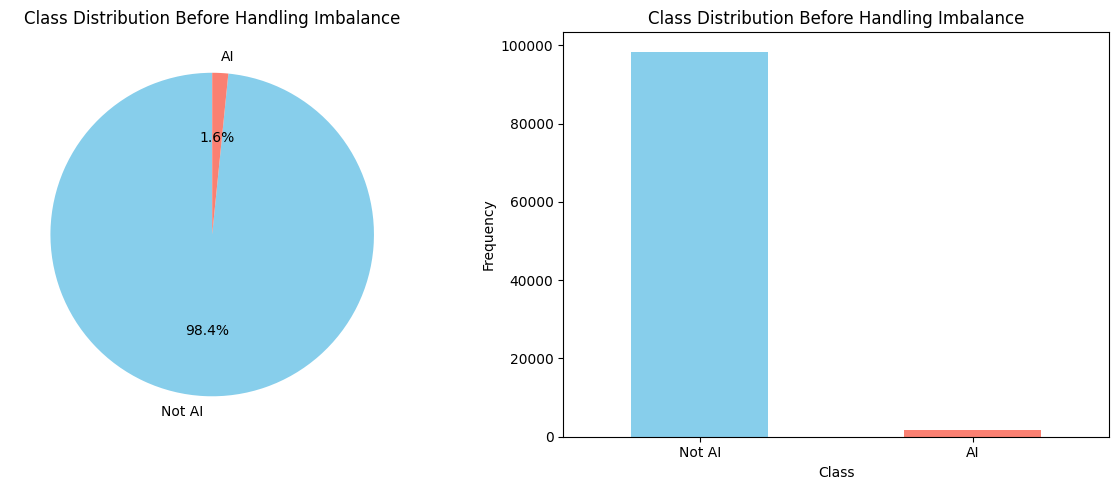

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize the class imbalance before handling - Pie Chart
labels.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=axes[0])
axes[0].set_title('Class Distribution Before Handling Imbalance')
axes[0].set_ylabel('')

# Visualize the class imbalance before handling - Bar Chart
labels.value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Class Distribution Before Handling Imbalance')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The dataset exhibits a significant class imbalance, with the "Not AI" class comprising `1,274,405` instances and the "AI" class comprising only `21,976` instances. 
- This imbalance can lead to biased model performance, where the model may favor the majority class.
- To address this issue, we will apply various resampling techniques such as `undersampling the majority class` and `oversampling the minority class`. This will help create a more balanced training set, improving the model's ability to learn from both classes effectively.

## Train/Test Split
When dealing with imbalanced datasets, it is crucial to **split the data into training and testing sets before applying oversampling or undersampling techniques:**
- *Avoid Data Leakage*: If you oversample or undersample before splitting, information from the testing set can leak into the training set. This can lead to overly optimistic performance estimates because the model has effectively "seen" some of the testing data during training.

- *Realistic Evaluation*: By splitting the data first, you ensure that the testing set remains a true representation of unseen data. This allows for a more realistic evaluation of the model's performance on new, unseen data.
- *Preserve Distribution*: Splitting the data first helps preserve the original distribution of the classes in the testing set. This is important for evaluating how well the model handles the natural imbalance in the data.


In [98]:
test_size = 0.25

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], data["label"], test_size=test_size, random_state=42
)

## Handling Class Imballance

While SMOTE (Synthetic Minority Over-sampling Technique) is a popular method for handling class imbalances, there are other techniques that can be considered, such as:

1. **ADASYN (Adaptive Synthetic Sampling)**: Similar to SMOTE, but focuses on generating synthetic samples for minority class examples that are harder to learn.
2. **Borderline-SMOTE**: A variant of SMOTE that generates synthetic samples only for minority class examples that are near the decision boundary.
3. **Cluster-Based Over-Sampling**: Uses clustering algorithms to identify regions of the feature space where synthetic samples should be generated.
4. **Ensemble Methods**: Techniques like Balanced Random Forest or EasyEnsemble that combine multiple models to handle class imbalance.

In [100]:
undersampling_methods = [
    ("NearMiss", NearMiss()),
    ("RandomUnderSampler", RandomUnderSampler(sampling_strategy=0.35, random_state=42)),
    ("TomekLinks", TomekLinks())
]

oversampling_methods = [
    ("SMOTE", SMOTE(random_state=42)),
    ("ADASYN", ADASYN(random_state=42)),
    ("RandomOverSampler", RandomOverSampler(random_state=42))
]

In [101]:
class ImbalanceHandler:
    def __init__(self, data, undersample_method=None, oversample_method=None):
        self.data = data
        self.text_column = 'text'
        self.label_column = 'label'

        # Vectorize text data
        self.vectorizer = TfidfVectorizer(max_features=5000)

        # Set undersampling and oversampling methods
        self.undersample = undersample_method if undersample_method else RandomUnderSampler(sampling_strategy=0.35, random_state=42)
        self.oversample = oversample_method if oversample_method else SMOTE(random_state=42)

        # Create pipeline
        self.pipeline = Pipeline(
            [
                ("tfidf", self.vectorizer),
                ("undersample", self.undersample),
                ("oversample", self.oversample),
            ]
        )

    def handle_imbalance(self):
        # Extract features and labels
        X = self.data[self.text_column]
        y = self.data[self.label_column]

        # Apply the pipeline
        # print("Resampling.")
        X_res, y_res = self.pipeline.fit_resample(X, y)

        # print('Completed handling class imbalance')

        return X_res, y_res

We will use a Random Forest Classifier to determin which method works better for our dataset

In [102]:
# Function to evaluate the model
def evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

In [103]:
def run_experiments(
    X_train, y_train, X_test, y_test, undersampling_methods, oversampling_methods
):
    # Initialize results dictionary
    results = []

    # Run experiments with different combinations of undersampling and oversampling methods
    for undersample_name, undersample_method in tqdm(undersampling_methods, desc="Undersampling Methods"):
        for oversample_name, oversample_method in tqdm(oversampling_methods, desc="Oversampling Methods", leave=False):
            print(f"Evaluating {undersample_name} + {oversample_name}...")

            # Initialize ImbalanceHandler with the current methods
            dataset = pd.DataFrame({"text": X_train, "label": y_train})
            imbalance_handler = ImbalanceHandler(
                dataset, undersample_method, oversample_method
            )
            X_res, y_res = imbalance_handler.handle_imbalance()

            # Evaluate the model
            accuracy, precision, recall, f1, fpr, tpr, roc_auc = evaluate_model(
                X_res, y_res, X_test, y_test
            )

            # Store the results
            results.append(
                {
                    "Undersampling Method": undersample_name,
                    "Oversampling Method": oversample_name,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1 Score": f1,
                    "fpr": fpr,
                    "tpr": tpr,
                    "ROC AUC": roc_auc,
                }
            )

    results_df = pd.DataFrame(results)

    return results_df

In [104]:
vectorizer = TfidfVectorizer(max_features=5000)
X_test_vectorized = vectorizer.fit_transform(X_test)

In [105]:
results_df = run_experiments(
    X_train,
    y_train,
    X_test_vectorized,
    y_test,
    undersampling_methods,
    oversampling_methods,
)

Undersampling Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Oversampling Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating NearMiss + SMOTE...
Evaluating NearMiss + ADASYN...
Evaluating NearMiss + RandomOverSampler...


Oversampling Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating RandomUnderSampler + SMOTE...
Evaluating RandomUnderSampler + ADASYN...
Evaluating RandomUnderSampler + RandomOverSampler...


Oversampling Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating TomekLinks + SMOTE...
Evaluating TomekLinks + ADASYN...
Evaluating TomekLinks + RandomOverSampler...


Save the results to file

In [106]:
imb_filename = os.path.join(data_dir, "d_class_imbalance_results.csv")
results_df.to_csv(imb_filename, index=False)
print(f"Results saved to {os.path.relpath(imb_filename, project_root)}")

Results saved to data/d_class_imbalance_results.csv


## Comparative analysis

### ROC Curve Review

ROC curve sorted by ROC AUC

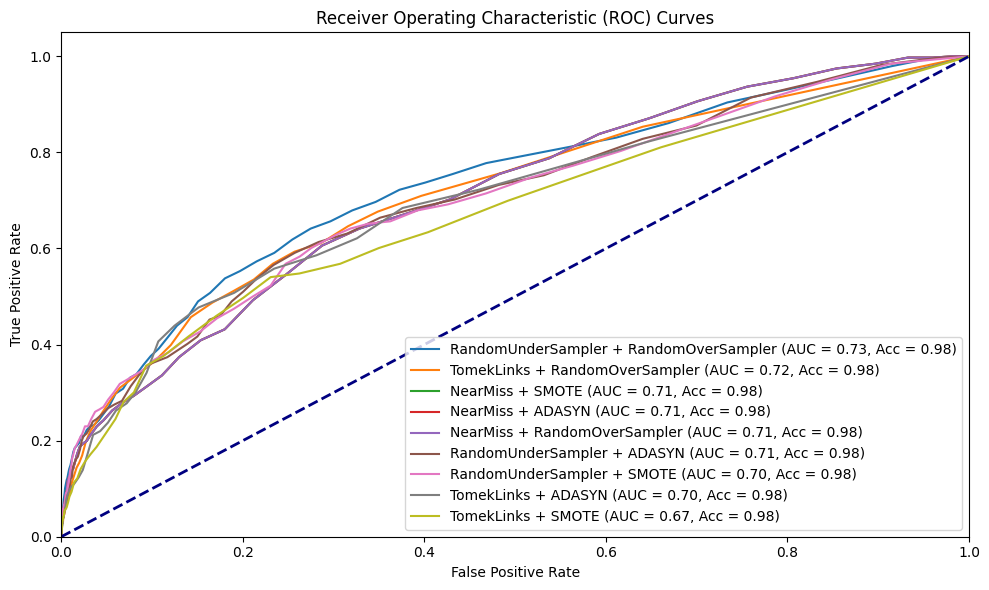

In [107]:
def plot_roc_curves(results_df, sort_column):
    # Sort the results by the specified column in descending order
    best_roc = results_df.sort_values(by=sort_column, ascending=False)

    # Plot the ROC curves for all the results
    _, ax = plt.subplots(figsize=(10, 6))

    for _, row in best_roc.iterrows():
        ax.plot(
            row["fpr"],
            row["tpr"],
            label=f"{row['Undersampling Method']} + {row['Oversampling Method']} (AUC = {row['ROC AUC']:.2f}, Acc = {row['Accuracy']:.2f})",
        )

    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic (ROC) Curves")
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    
plot_roc_curves(results_df, "ROC AUC")

### Accuracy Comparison

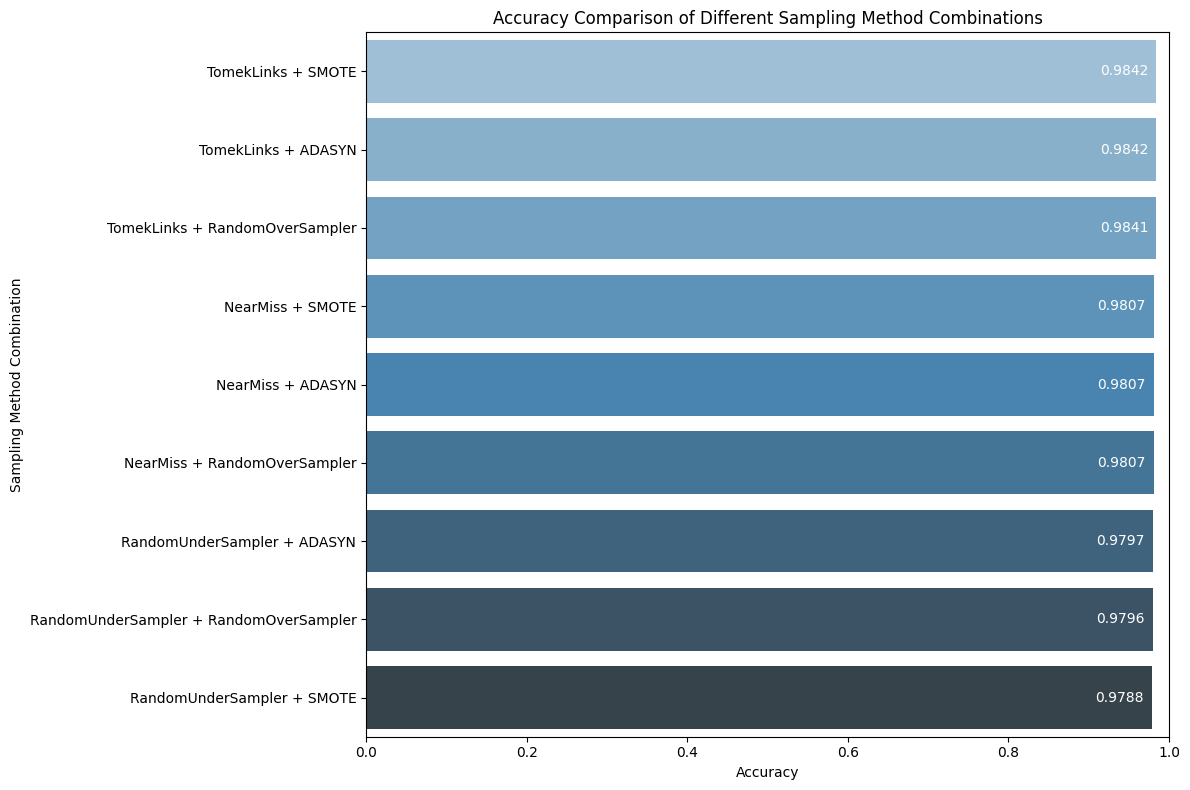

In [108]:
def plot_accuracy_comparison(results_df, sort_by="Accuracy"):
    # Sort the results by accuracy in descending order
    sorted_results = results_df.sort_values(by=sort_by, ascending=False)

    # Create a new column for the combination of undersampling and oversampling methods
    sorted_results["Sampling Method Combination"] = sorted_results["Undersampling Method"] + " + " + sorted_results["Oversampling Method"]

    # Plot the accuracy comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        y="Sampling Method Combination",
        x="Accuracy",
        data=sorted_results,
        palette="Blues_d",
        hue="Sampling Method Combination",
        dodge=False,
        legend=False
    )
    plt.xlabel("Accuracy")
    plt.ylabel("Sampling Method Combination")
    plt.title("Accuracy Comparison of Different Sampling Method Combinations")
    plt.xlim(0, 1)  # Set x-axis limit to prevent overflow

    # Add values to the bars
    for p in ax.patches:
        width = p.get_width()
        if width < 0.1:
            plt.text(width + 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center')
        else:
            plt.text(width - 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='right', va='center', color='white')

    plt.tight_layout()
    plt.show()

plot_accuracy_comparison(results_df)

### Recall Comparison

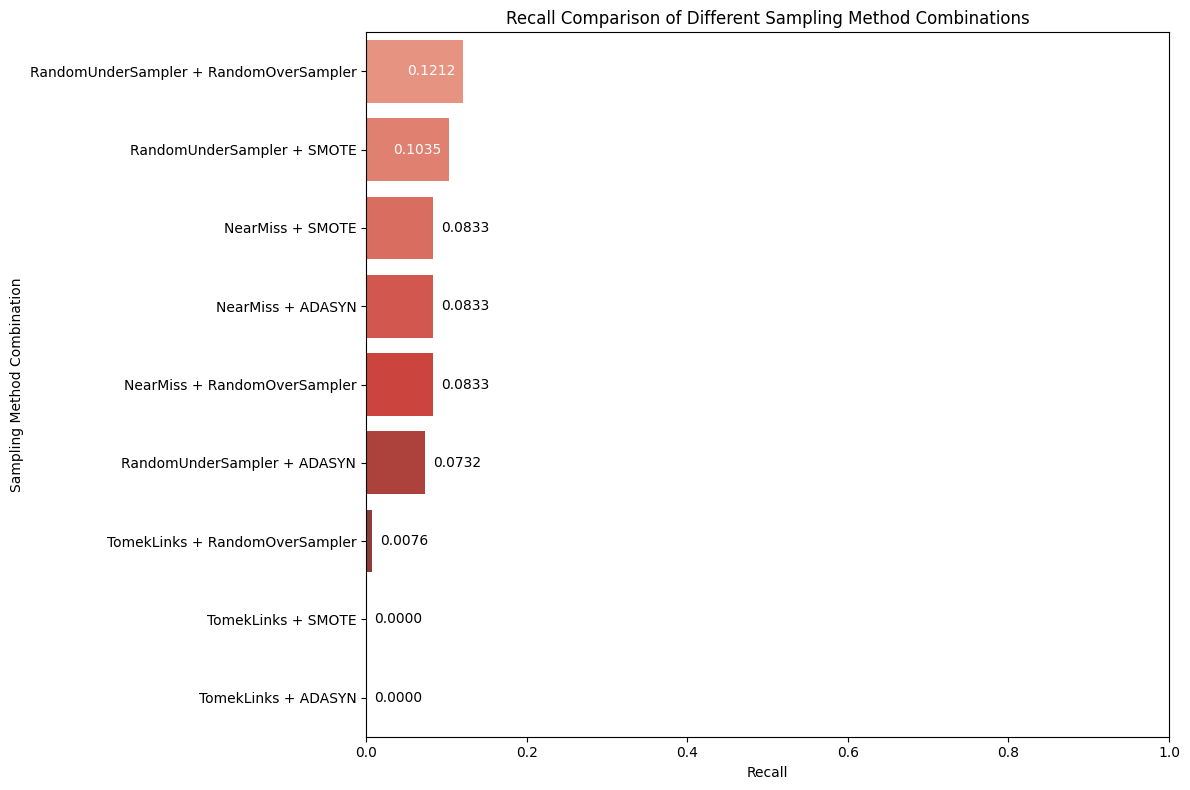

In [109]:
def plot_recall_comparison(results_df):
    # Sort the results by recall in descending order
    sorted_results_recall = results_df.sort_values(by="Recall", ascending=False)

    # Create a new column for the combination of undersampling and oversampling methods
    sorted_results_recall["Sampling Method Combination"] = sorted_results_recall["Undersampling Method"] + " + " + sorted_results_recall["Oversampling Method"]

    # Plot the recall comparison
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        y="Sampling Method Combination",
        x="Recall",
        data=sorted_results_recall,
        palette="Reds_d",
        hue="Sampling Method Combination",
        dodge=False,
        legend=False
    )
    plt.xlabel("Recall")
    plt.ylabel("Sampling Method Combination")
    plt.title("Recall Comparison of Different Sampling Method Combinations")
    plt.xlim(0, 1)  # Set x-axis limit to prevent overflow

    # Add values to the bars
    for p in ax.patches:
        width = p.get_width()
        if width < 0.1:
            plt.text(width + 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center')
        else:
            plt.text(width - 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='right', va='center', color='white')

    plt.tight_layout()
    plt.show()

plot_recall_comparison(results_df)


### Precision Comparison

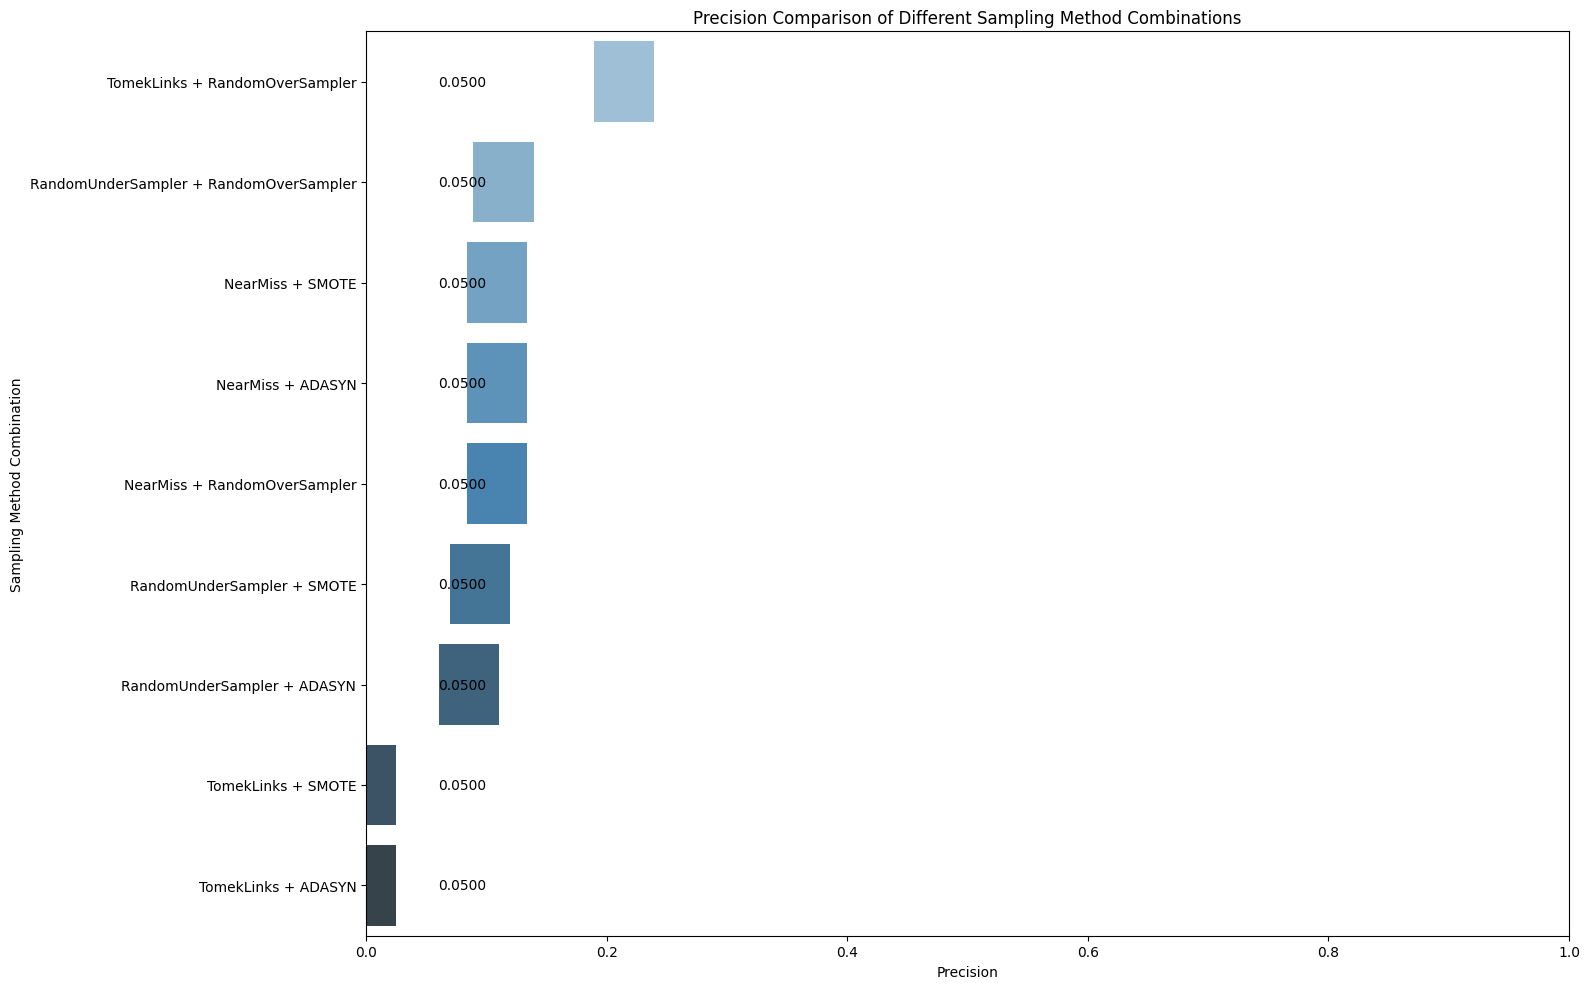

In [110]:
def plot_precision_comparison(results_df):
    # Sort the results by precision in descending order
    sorted_results_precision = results_df.sort_values(by="Precision", ascending=False)

    # Create a new column for the combination of undersampling and oversampling methods
    sorted_results_precision["Sampling Method Combination"] = sorted_results_precision["Undersampling Method"] + " + " + sorted_results_precision["Oversampling Method"]

    # Plot the precision comparison
    plt.figure(figsize=(16, 10))  # Increase the figure size
    ax = sns.barplot(
        y="Sampling Method Combination",
        x="Precision",
        data=sorted_results_precision,
        palette="Blues_d",
        hue="Sampling Method Combination",
        dodge=False,
        legend=False
    )
    plt.xlabel("Precision")
    plt.ylabel("Sampling Method Combination")
    plt.title("Precision Comparison of Different Sampling Method Combinations")
    plt.xlim(0, 1)  # Set x-axis limit to prevent overflow

    # Increase the bar width
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = 0.05 - current_width
        patch.set_width(0.05)
        patch.set_x(patch.get_x() - diff / 2)

    # Add values to the bars
    for p in ax.patches:
        width = p.get_width()
        if width < 0.1:
            plt.text(width + 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center')
        else:
            plt.text(width - 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='right', va='center', color='white')

    plt.tight_layout()
    plt.show()
    
plot_precision_comparison(results_df)

### F1 Score Comparison

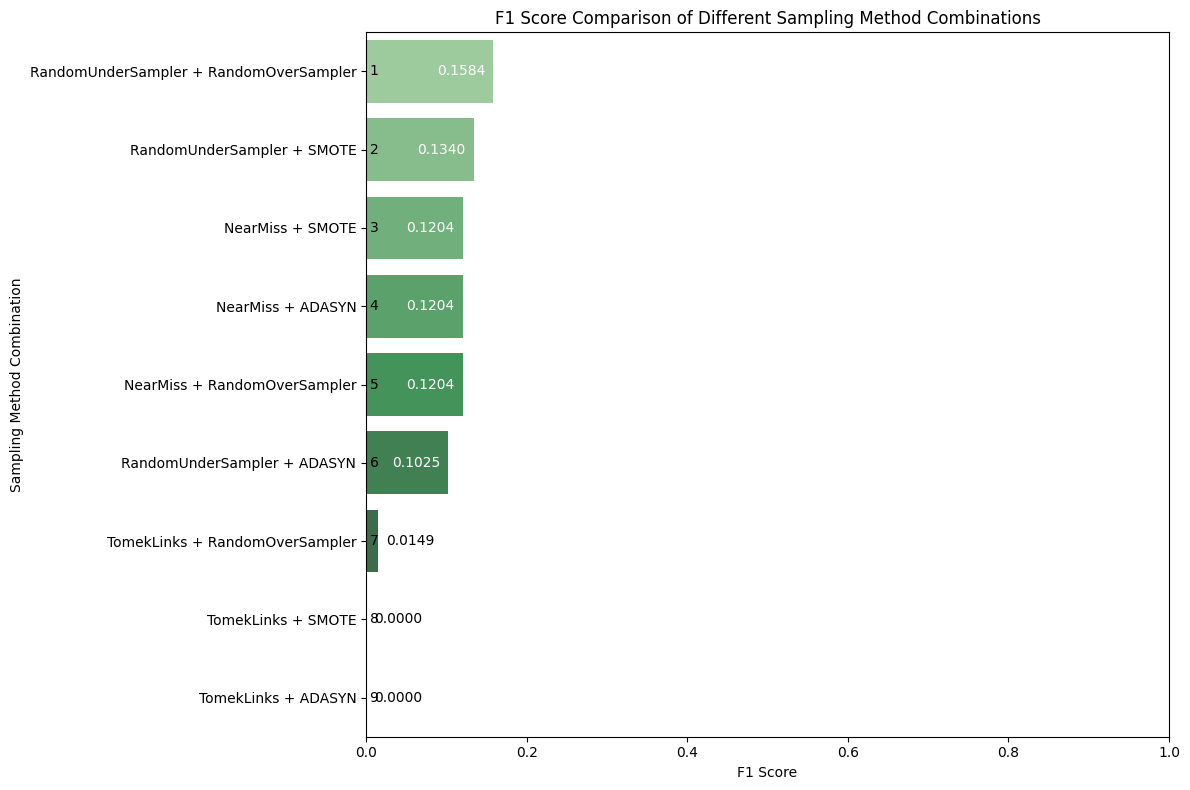

In [111]:
def plot_f1_comparison(results_df):
    # Sort the results by F1 Score in descending order
    sorted_results = results_df.sort_values(by="F1 Score", ascending=False)

    # Create a new column for the combination of undersampling and oversampling methods
    sorted_results["Sampling Method Combination"] = sorted_results["Undersampling Method"] + " + " + sorted_results["Oversampling Method"]

    # Plot the F1 Score comparison
    plt.figure(figsize=(12, 8))  # Adjust the figure size
    ax = sns.barplot(
        y="Sampling Method Combination",
        x="F1 Score",
        data=sorted_results,
        palette="Greens_d",
        hue="Sampling Method Combination",
        dodge=False,
        legend=False
    )
    plt.xlabel("F1 Score")
    plt.ylabel("Sampling Method Combination")
    plt.title("F1 Score Comparison of Different Sampling Method Combinations")
    plt.xlim(0, 1)  # Set x-axis limit to prevent overflow

    # Add values to the bars
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        if width < 0.1:
            plt.text(width + 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='left', va='center')
        else:
            plt.text(width - 0.01, p.get_y() + p.get_height() / 2, f'{width:.4f}', ha='right', va='center', color='white')
        plt.text(0.01, p.get_y() + p.get_height() / 2, f'{i + 1}', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

plot_f1_comparison(results_df)

## Review class imballance handling with the best 2 methods

In [112]:
best_accuracy_method = results_df.sort_values(by="Accuracy", ascending=False).iloc[0]
best_accuracy_method_under = best_accuracy_method["Undersampling Method"]
best_accuracy_method_over = best_accuracy_method["Oversampling Method"]

best_roc_auc_method = results_df.sort_values(by="ROC AUC", ascending=False).iloc[0]
best_roc_auc_method_under = best_roc_auc_method["Undersampling Method"]
best_roc_auc_method_over = best_roc_auc_method["Oversampling Method"]

print(f"Best Accuracy: {best_accuracy_method_under} + {best_accuracy_method_over}")
print(f"Best ROC AUC: {best_roc_auc_method_under} + {best_roc_auc_method_over}")

Best Accuracy: TomekLinks + SMOTE
Best ROC AUC: RandomUnderSampler + RandomOverSampler


In [113]:
# Initialize ImbalanceHandler with the best methods for accuracy
best_accuracy_handler = ImbalanceHandler(
    pd.DataFrame({"text": X_train, "label": y_train}),
    undersample_method=eval(best_accuracy_method_under)(),
    oversample_method=eval(best_accuracy_method_over)()
)
X_res_acc, y_res_acc = best_accuracy_handler.handle_imbalance()

# Initialize ImbalanceHandler with the best methods for ROC AUC
best_roc_auc_handler = ImbalanceHandler(
    pd.DataFrame({"text": X_train, "label": y_train}),
    undersample_method=eval(best_roc_auc_method_under)(),
    oversample_method=eval(best_roc_auc_method_over)()
)
X_res_roc, y_res_roc = best_roc_auc_handler.handle_imbalance()

# Vectorize the test set
X_test_vectorized = vectorizer.transform(X_test)

X_test_vectorized

# Evaluate the models
accuracy_metrics = evaluate_model(X_res_acc, y_res_acc, X_test_vectorized, y_test)
roc_auc_metrics = evaluate_model(X_res_roc, y_res_roc, X_test_vectorized, y_test)

In [114]:
# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "Best Accuracy Method": [accuracy_metrics[0], accuracy_metrics[1], accuracy_metrics[2], accuracy_metrics[3], accuracy_metrics[6]],
    "Best ROC AUC Method": [roc_auc_metrics[0], roc_auc_metrics[1], roc_auc_metrics[2], roc_auc_metrics[3], roc_auc_metrics[6]]
})

# Display the DataFrame
metrics_df


,Metric,Best Accuracy Method,Best ROC AUC Method
0,Accuracy,0.984160,0.979240
1,Precision,0.500000,0.181347
2,Recall,0.002525,0.088384
3,F1 Score,0.005025,0.118846
4,ROC AUC,0.695738,0.735344


**Review balanced data**
- After applying the resampling techniques, it is important to review the class distribution to ensure that the imbalance has been addressed effectively. 
- Below, we will visualize the class distribution for both the best accuracy method and the best ROC AUC method.


Label value counts after resampling (Best Accuracy Method):
label
Not AI    73697
AI        73697
Name: count, dtype: int64


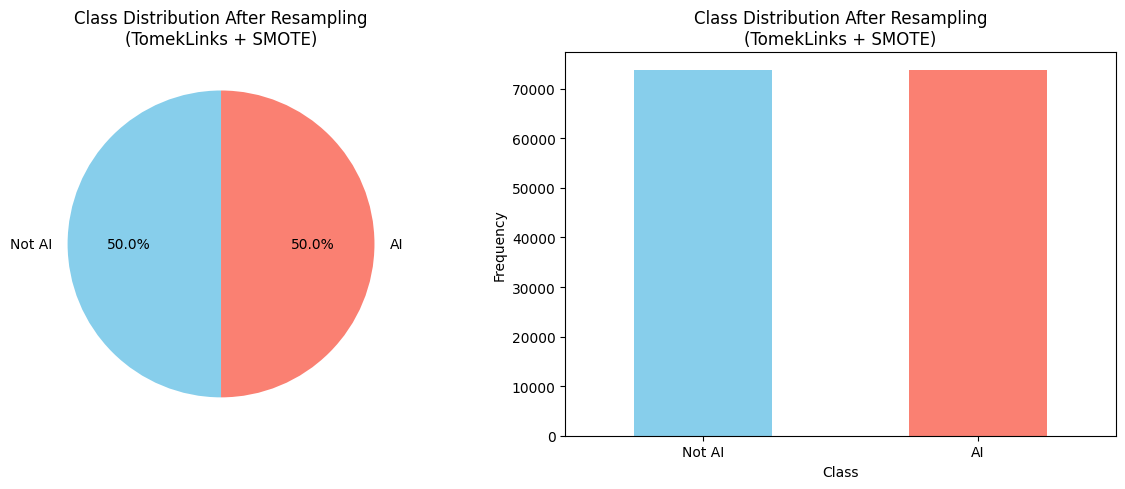

Label value counts after resampling (Best ROC AUC Method):
label
Not AI    1198
AI        1198
Name: count, dtype: int64


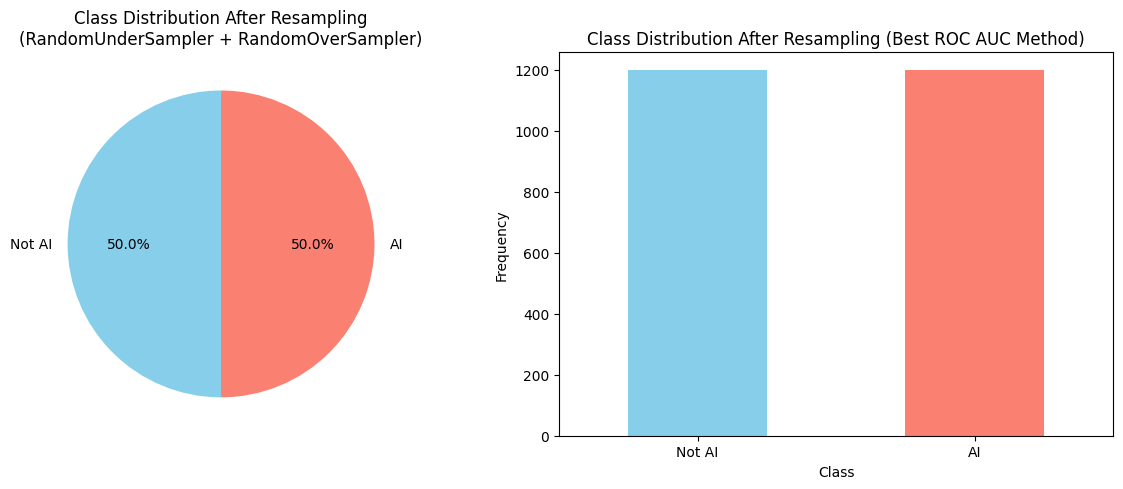

In [115]:
def visualize_resampled_class_distribution(y_res_acc, y_res_roc, best_accuracy_method, best_roc_auc_method):
    # Map labels
    y_res_acc_mapped = y_res_acc.map({0: "Not AI", 1: "AI"})
    y_res_roc_mapped = y_res_roc.map({0: "Not AI", 1: "AI"})

    print("Label value counts after resampling (Best Accuracy Method):")
    print(y_res_acc_mapped.value_counts())
    print("=========================================================")

    # Visualize the class distribution after resampling for the best accuracy method
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Best Accuracy Method
    y_res_acc_mapped.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=ax[0])
    ax[0].set_title(f'Class Distribution After Resampling\n({best_accuracy_method["Undersampling Method"]} + {best_accuracy_method["Oversampling Method"]})')
    ax[0].set_ylabel('')

    y_res_acc_mapped.value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=ax[1])
    ax[1].set_title(f'Class Distribution After Resampling\n({best_accuracy_method["Undersampling Method"]} + {best_accuracy_method["Oversampling Method"]})')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Frequency')
    ax[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

    print("Label value counts after resampling (Best ROC AUC Method):")
    print(y_res_roc_mapped.value_counts())
    print("=========================================================")

    # Visualize the class distribution after resampling for the best ROC AUC method
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Best ROC AUC Method
    y_res_roc_mapped.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'], ax=ax[0])
    ax[0].set_title(f'Class Distribution After Resampling\n({best_roc_auc_method["Undersampling Method"]} + {best_roc_auc_method["Oversampling Method"]})')
    ax[0].set_ylabel('')

    y_res_roc_mapped.value_counts().plot(kind='bar', color=['skyblue', 'salmon'], ax=ax[1])
    ax[1].set_title('Class Distribution After Resampling (Best ROC AUC Method)')
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Frequency')
    ax[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

visualize_resampled_class_distribution(y_res_acc, y_res_roc, best_accuracy_method, best_roc_auc_method)